In [1]:
%load_ext autoreload
%autoreload 2

# Demo 3: Learn Airfoil Parameters

_This tutorial is useful for assessing the efficiency of JENN on datasets of practical size._

The data for this tutorial is copied from [SMT](https://smt.readthedocs.io/en/stable/_src_docs/examples/airfoil_parameters/learning_airfoil_parameters.html). It provides an example with a large dataset on the order 40,000 examples. The goal is to predict airfoil drag coefficient $c_d$ as a function of 16 inputs that define airfoil shape and flight condition (see their paper below).

> [Bouhlel, M. A., He, S., & Martins, J. R. (2019). mSANN Model Benchmarks, Mendeley Data](https://doi.org/10.17632/ngpd634smf.1)

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import random
import jenn

## Load Data

In [3]:
X = np.loadtxt("data/cd_x_y.csv", delimiter=";", dtype=float)[:, :-1].T  
Y = np.loadtxt("data/cd_x_y.csv", delimiter=";", dtype=float)[:, -1].reshape((-1, 1)).T  
J = np.loadtxt("data/cd_dy.csv", delimiter=";", dtype=float).T

In [4]:
n_x, m = X.shape
n_y, _ = Y.shape 
print(f"number of inputs = {n_x}")
print(f"number of outputs = {n_y}")
print(f"number of examples = {m}")

number of inputs = 16
number of outputs = 1
number of examples = 42039


## Split Data

_Hold back 20% of the data for testing._

In [5]:
test = random.sample(range(0, m), m // 5)
train = list(set(range(m)).difference(set(test)))

In [6]:
X_train = X[:, train].reshape((n_x, -1))
Y_train = Y[:, train].reshape((n_y, -1))
J_train = J[:, train].reshape((n_y, n_x, -1))

In [7]:
X_test = X[:, test].reshape((n_x, -1))
Y_test = Y[:, test].reshape((n_y, -1))
J_test = J[:, test].reshape((n_y, n_x, -1))

## Fit Model

_Takes about 1min to run_

In [8]:
%%time
model = jenn.NeuralNet(
    layer_sizes=[n_x, 12, 12, n_y],
).fit(
    x=X_train, 
    y=Y_train, 
    dydx=J_train, 
    alpha=1e-2, 
    lambd=1e-2, 
    gamma=1.0,
    is_backtracking=False, 
    is_normalize=True,
    is_verbose=False, 
    max_iter=2, 
    batch_size=1000,  # minibatch helps speed up training for large datasets
    epochs=25,
)

CPU times: user 10.5 s, sys: 1.9 s, total: 12.4 s
Wall time: 12.4 s


## Convergence

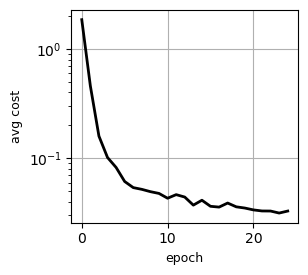

In [9]:
jenn.plot_convergence(model.history)

## Goodness of Fit

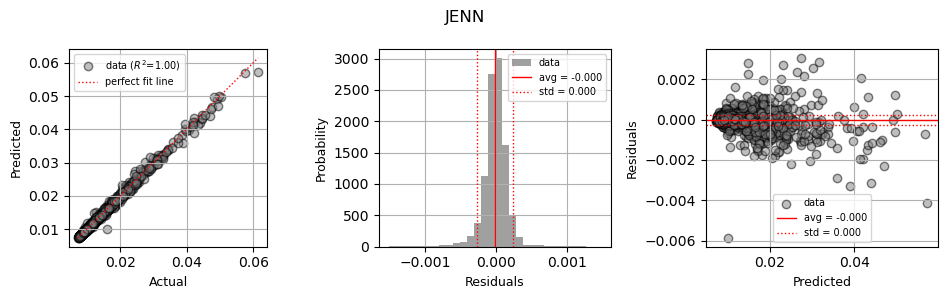

In [14]:
jenn.plot_goodness_of_fit(y_pred=model.predict(X_test), y_true=Y_test, title="JENN", percent=False)

## Sensitivity Profiles

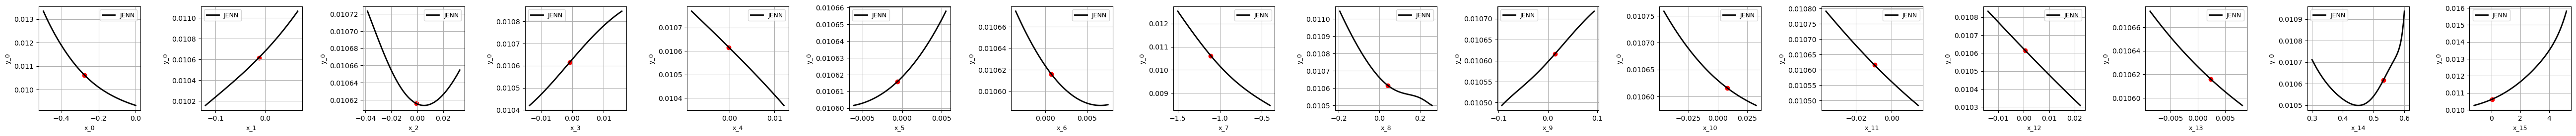

In [15]:
jenn.plot_sensitivity_profiles(
    func=model.predict, 
    x0=X_test[:, np.random.randint(0, X_test.shape[-1])],
    x_min=X_test.min(axis=1), 
    x_max=X_test.max(axis=1), 
    legend_label="JENN",
    legend_fontsize=9, 
) # note: double-click output cell to make bigger and scroll